# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading data

In [2]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y, X = train['label'], train.loc[:, train.columns != 'label'] / 255

Split into training and testing sets for possible use later. Also, I wanted to check if the dicitinary works well with new data

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
X_train, X_test = X_train.values, X_test.values

In [24]:
X_train = X_train.reshape([X_train.shape[0], 28*28])
X_test = X_test.reshape([X_test.shape[0], 28*28])

# Goal
Mnist digit to dictionary and then back to digit

In [23]:
batch_size = 1680
epsilon = 1e-6
num_filters = 100
patches_per_img = 4
data_size = X_train.shape[0]
num_batches = data_size // batch_size
alpha = 0.01 #learning rate
sparsity_coef = 1 # sparsity coef
beta = .99 #The amount to retain for A and B
img_size = 28
dict_filter_size = img_size**2 //patches_per_img
activity_epochs = 300
epochs=30

In [24]:
X_train = X_train.reshape([-1, dict_filter_size])
X_test = X_test.reshape([-1, dict_filter_size]) 

# ZCA Preprocessing

In [25]:
def zca(x):
    cov = np.cov(x)
    mean = x.mean()
    w, v = np.linalg.eig(cov)
    w_output = 1/(np.sqrt(w+1e-5))
    output = v @ np.diag(w_output) @ v.T @ (x - mean)
    return output

# Tensorflow graph

In [26]:
def matmul_1d(a, b):
    return tf.einsum('ij,j->i', a, b)
def batch_matmul_1d(a, b):
    return tf.einsum('ij,kj->ki', a, b)

In [36]:
class Activity(keras.layers.Layer):
    def __init__(self, units=num_filters, batch_size=batch_size, alpha=alpha, sparsity_coef=sparsity_coef):
        super(Activity, self).__init__()
        self.w_init = tf.random_normal_initializer()
        self.batch_size = batch_size
        self.units = units
        self.w = tf.Variable(
            initial_value=self.w_init(shape=(batch_size, units), dtype="float32"),
            trainable=False,
        )
        self.rate = alpha
        self.sparsity_coef = sparsity_coef
    def shrink(self):
        a = self.w
        b = self.rate * self.sparsity_coef
        prior_shrink = tf.abs(a) - b
        shrink_positive = tf.clip_by_value(prior_shrink, 0, np.inf)
        sign_a = tf.math.sign(a)
        a.assign(sign_a * prior_shrink)
    def update(self, dictionary, x):
        tf.debugging.assert_all_finite(self.w, 'Check activity weights finite')
        batch_size = x.shape[0]
        
        self.w[:batch_size].assign(self.w[:batch_size]-self.rate* \
            tf.einsum('ij, ki->kj', dictionary, (tf.einsum('ij,kj->ki', dictionary, self.w[:batch_size])-x)))
        self.shrink()
    def reset(self):
        self.w.assign(self.w_init(shape=(self.batch_size, self.units), dtype="float32"))
    def call(self, dictionary, batch_size=batch_size):
        return batch_matmul_1d(dictionary, self.w[:batch_size])

In [37]:
class Dictionary(keras.layers.Layer):
    def __init__(self, units=num_filters, dict_filter_size=dict_filter_size, beta=beta):
        super(Dictionary, self).__init__()
        w_init = tf.random_normal_initializer()
        self.units = units
        self.A = tf.Variable(
            initial_value=w_init(shape=(units, units), dtype="float32"),
            trainable=False,
        )
        self.B = tf.Variable(
            initial_value=w_init(shape=(dict_filter_size, units), dtype="float32"),
            trainable=False,
        )
        self.w =  tf.Variable(
            initial_value=w_init(shape=(dict_filter_size, units), dtype="float32"),
            trainable=False,
        )
    def call(self, inputs, activity):
        return tf.matmul(self.dictionary, activity)
    def update_AB(self, activity, x):
        tf.debugging.assert_all_finite(self.w, 'Check A finite')
        tf.debugging.assert_all_finite(self.w, 'Check B finite')
        batch_size = x.shape[0]
        self.A.assign(beta*self.A + (1-beta)*tf.reduce_mean(\
            tf.einsum('ij,ik->ijk', activity[:batch_size], activity[:batch_size]), axis=0))
        self.B.assign(beta*self.B + (1-beta)*tf.reduce_mean(tf.einsum('ij,ik->ijk', x, activity[:batch_size]), axis=0))
    def update(self):
        tf.debugging.assert_all_finite(self.w, 'Check dictionary weights finite')
        for i in range(self.units):
            self.w[:, i].assign(1/(self.A[i, i]+epsilon) * (self.B[:, i] - tf.einsum('ij,j->i',self.w,self.A[:, i])+self.w[:, i]*self.A[i, i]))
            self.w[:, i].assign(self.w[:, i] / tf.norm(self.w[:, i])+epsilon)

In [38]:
def dictionary_loss(dictionary, activity, x):
    return tf.reduce_mean(0.5*tf.square(tf.einsum('ij,kj->ki', dictionary, activity) - x))
def sparsity_loss(activity, sparsity_coef):
    return tf.abs(activity)*sparsity_coef

In [39]:
class SparseModel(keras.Model):
    def __init__(self, activity, dictionary, activity_epochs=activity_epochs, dict_filter_size=dict_filter_size, \
                data_size=data_size, batch_size = batch_size):
        super(SparseModel, self).__init__()
        self.activity = activity
        self.dictionary = dictionary
        self.dict_filter_size = dict_filter_size
        self.data_size = data_size
        self.batch_size = batch_size
        self.batch_num = data_size // batch_size + (1 if (self.data_size % self.batch_size) else 0)
    def compile(self, sparsity_loss, dictionary_loss):
        super(SparseModel, self).compile()
        self.sparsity_loss = sparsity_loss
        self.dictionary_loss = dictionary_loss
    @tf.function
    def train_step_end(self):
        if self._train_counter % self.batch_num == 0:
            self.dictionary.update()
    def train_step(self, patches):
        patches = tf.cast(patches, dtype=tf.float32)
        batch_size = patches.shape[0]
        patches = tf.reshape(patches, [-1, self.dict_filter_size])
        self.activity.reset()
        
        dictionary = self.dictionary.w
        activity = self.activity.w
        for _ in range(activity_epochs):
            self.activity.update(dictionary, patches)
        dictionary_loss = self.dictionary_loss(dictionary, activity, patches)
        tf.debugging.assert_all_finite(dictionary_loss, 'Check dictionary loss')
        sparsity_loss = self.sparsity_loss(activity, self.activity.rate*self.activity.sparsity_coef)
        tf.debugging.assert_all_finite(sparsity_loss, 'Check sparsity loss')
        self.dictionary.update_AB(activity, patches)
        self.train_step_end()
        return {'dictionary loss': dictionary_loss, 'sparsity loss': sparsity_loss}
    def call(self, patches):
        patches = tf.cast(patches, dtype=tf.float32)
        patches = tf.reshape(patches, [-1, self.dict_filter_size])
        dictionary = self.dictionary.w
        for _ in range(activity_epochs):
            self.activity.update(dictionary, patches)
        return self.activity.call(self.dictionary.w, batch_size=patches.shape[0])

In [40]:
sparse_activity = Activity(units=num_filters, alpha=alpha, sparsity_coef=sparsity_coef)
sparse_dictionary = Dictionary(units=num_filters, dict_filter_size=dict_filter_size, beta=beta)
sparse_model = SparseModel(sparse_activity, sparse_dictionary)
sparse_model.compile(sparsity_loss, dictionary_loss)
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(X_train.reshape([-1, dict_filter_size, 1, 1]))
train_generator = datagen.flow(X_train.reshape([-1, dict_filter_size, 1, 1]), batch_size=batch_size)

In [41]:
sparse_model.fit(train_generator, epochs=epochs, batch_size=batch_size)

Epoch 1/30
67/67 [==============================] - 34s 278ms/step - dictionary loss: 0.3779 - sparsity loss: 0.0010
Epoch 2/30
67/67 [==============================] - 19s 279ms/step - dictionary loss: 0.3852 - sparsity loss: 9.5062e-04
Epoch 3/30
67/67 [==============================] - 18s 263ms/step - dictionary loss: 0.3603 - sparsity loss: 0.0010
Epoch 4/30
67/67 [==============================] - 19s 277ms/step - dictionary loss: 0.3365 - sparsity loss: 0.0011
Epoch 5/30
67/67 [==============================] - 19s 277ms/step - dictionary loss: 0.3215 - sparsity loss: 0.0011
Epoch 6/30
67/67 [==============================] - 19s 277ms/step - dictionary loss: 0.3116 - sparsity loss: 0.0012
Epoch 7/30
67/67 [==============================] - 19s 277ms/step - dictionary loss: 0.3045 - sparsity loss: 0.0012
Epoch 8/30
67/67 [==============================] - 19s 275ms/step - dictionary loss: 0.2993 - sparsity loss: 0.0012
Epoch 9/30
67/67 [==============================] - 19s 275m

# Filters

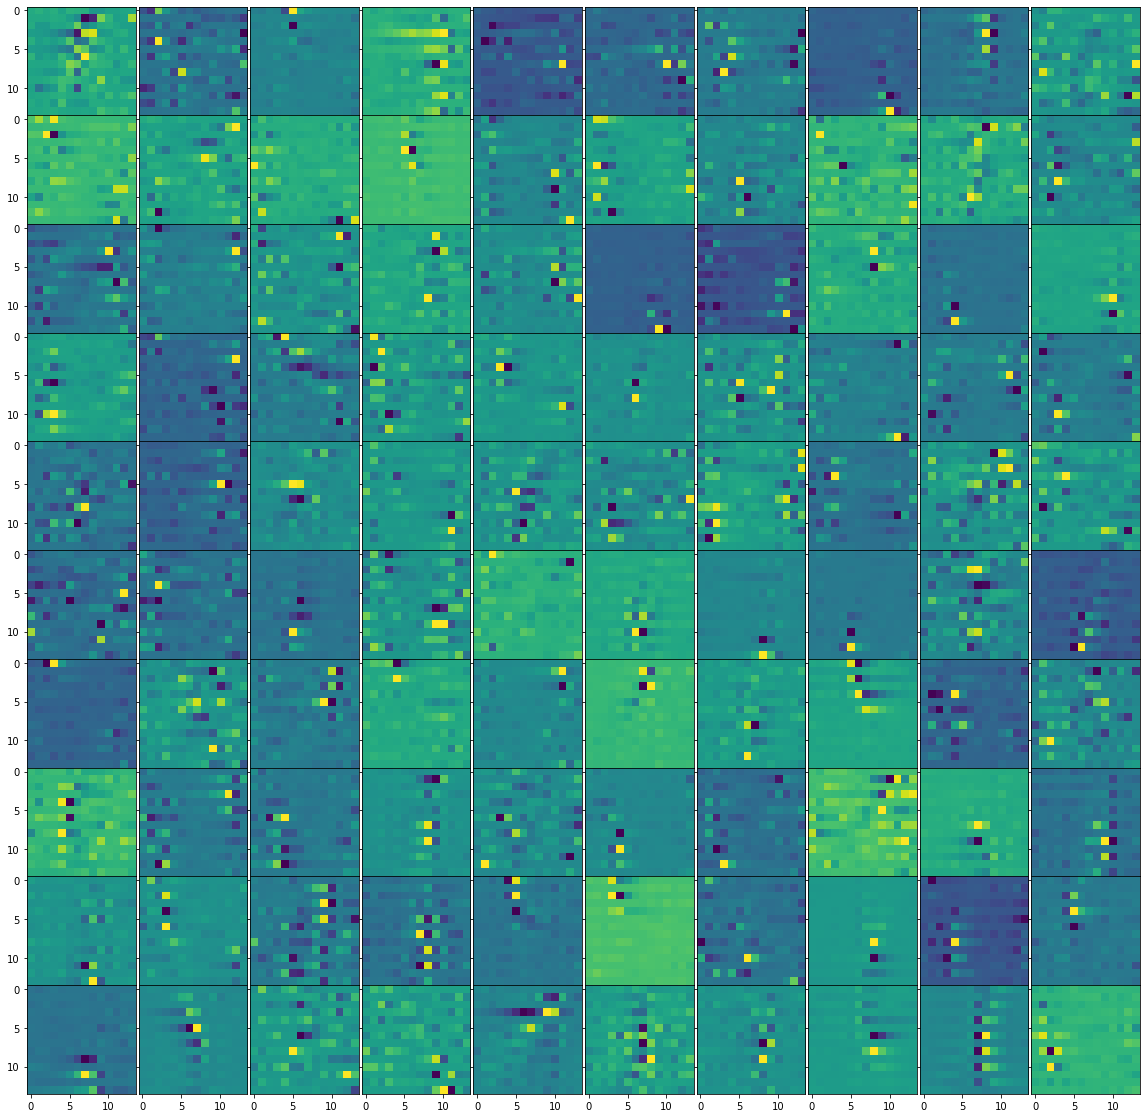

In [42]:
fig = plt.figure(figsize=(20, 20))
num_cols = 10
gs = fig.add_gridspec(num_filters //num_cols, num_cols, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_filters):
    axs[i // num_cols][i % num_cols].imshow(tf.reshape(sparse_model.dictionary.w[:, i], shape=[14,14]))
plt.show()

# Reconstructions

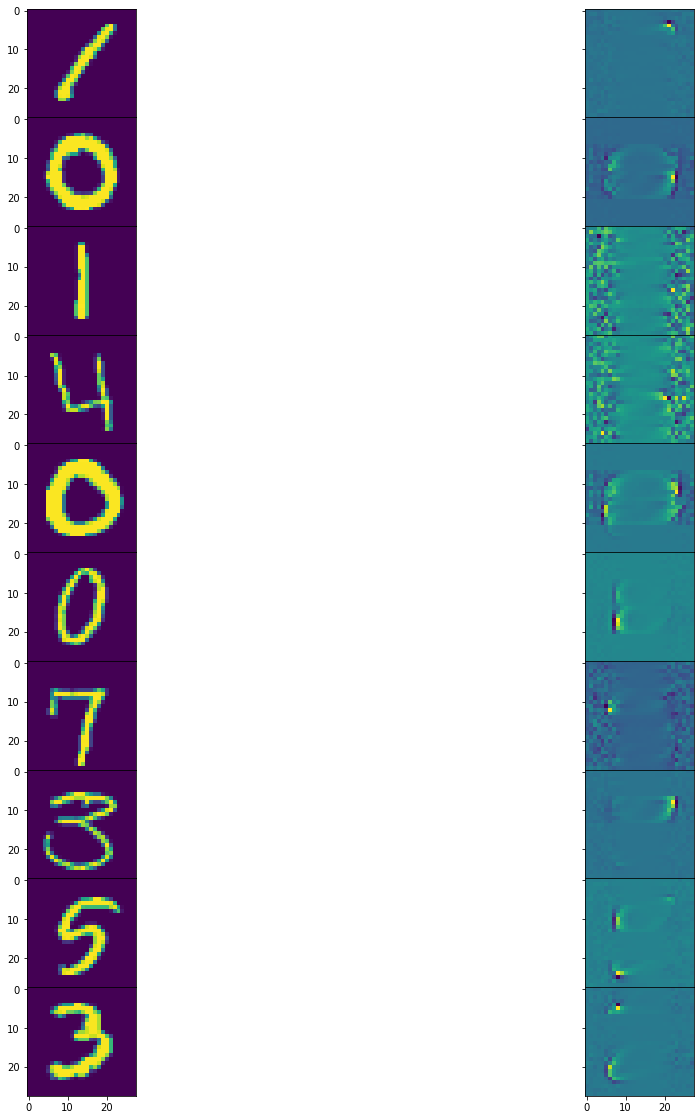

In [45]:
num_reconstructions = 10
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(num_reconstructions, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_reconstructions):
    axs[i][0].imshow(X.values[i].reshape([28, 28]))
    reconstructions = sparse_model.call(X.values[i].reshape([-1, dict_filter_size, 1, 1]))
    axs[i][1].imshow(tf.reshape(reconstructions, [28, 28]))
plt.show()

# Observations
- If not enough filters, the model chooses to decrease sparsity loss while barely decreasing dictionary loss